# create labels for 5 classes

In [1]:
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import time
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, cosine_distances

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [2]:
# start bert server
# !docker start bert-as-service

In [3]:
from bert_serving.client import BertClient
bc = BertClient()

# load dataset with encodings

In [4]:
dataset_path = Path('../../data')

In [5]:
full_ann_df = pd.read_pickle(str(dataset_path/'annotations.pkl'))
full_ann_df.rename(columns={'encoding': 'bert_emb'}, inplace=True)

In [6]:
#.copy() #.sample(2000) #.iloc[:1000]
ann_df = full_ann_df.copy()
# ann_df = full_ann_df.sample(1000)

In [7]:
ann_df

,sample_id,annotation,bert_emb
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4..."
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958..."
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635..."
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338..."
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279..."
...,...,...,...
6348,3961,a person running and stepipng over one step,"[-0.47801474, -0.1861707, 0.11223907, 0.024005..."
6349,3962,A person runs straight forward.,"[-0.08496222, -0.15005654, -0.46497947, -0.143..."
6350,3964,A person is sprinting up and down a small hill...,"[-0.30929312, -0.17201833, -0.26598853, 0.0950..."
6351,3965,"A person runs forward, briefly touches the gro...","[-0.16391394, 0.08974507, -0.103834555, 0.0485..."


# do PCA

In [8]:
n_pca_components = 5

X = np.stack(ann_df.bert_emb.to_numpy(), axis=0)
print(X.shape)

pca = PCA(n_components=n_pca_components)
pca_result = pca.fit_transform(X)

ann_df['pca_emb'] = [np.squeeze(x) for x in np.split(pca_result, pca_result.shape[0])]

(6353, 768)


In [9]:
ann_df.head()

,sample_id,annotation,bert_emb,pca_emb
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4...","[-0.87695, -2.566838, 0.52277964, -0.27487305,..."
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958...","[1.085087, -2.0609736, -0.03860944, 1.3155121,..."
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635...","[-3.6636589, -1.0734961, -1.7742416, 2.2865682..."
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338...","[0.35278884, -2.2448692, 0.37871817, 0.0891162..."
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279...","[-0.018057426, -0.6159681, -1.5479001, 4.80179..."


# do k-means clustering...

In [10]:
n_clusters = 5

time_start = time.time()

X = np.stack(ann_df.pca_emb.to_numpy(), axis=0)
print(X.shape)

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=10000, n_init=10)
kmeans.fit(X)
print('k-means done! Time elapsed: {} seconds'.format(time.time()-time_start))

(6353, 5)
k-means done! Time elapsed: 0.16503500938415527 seconds


In [11]:
prediction = kmeans.predict(X)
ann_df['center_idx'] = prediction
print(prediction[:10])
ann_df.head()

[4 1 4 4 1 1 4 3 1 1]


,sample_id,annotation,bert_emb,pca_emb,center_idx
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4...","[-0.87695, -2.566838, 0.52277964, -0.27487305,...",4
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958...","[1.085087, -2.0609736, -0.03860944, 1.3155121,...",1
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635...","[-3.6636589, -1.0734961, -1.7742416, 2.2865682...",4
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338...","[0.35278884, -2.2448692, 0.37871817, 0.0891162...",4
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279...","[-0.018057426, -0.6159681, -1.5479001, 4.80179...",1


# ...and create classes from clusters

In [12]:
pca_centers = kmeans.cluster_centers_
print(f'pca_centers.shape: {pca_centers.shape}')

class_idxs = list(range(n_clusters))
centers_df = pd.DataFrame({
    'center_idx': class_idxs,
    'class_name': [f'class_{x}' for x in class_idxs]
}, index=class_idxs)
# centers_df.index.name = 'center_idx'
centers_df['pca_center'] = [pca_centers[x] for x in range(pca_centers.shape[0])]
print(f'len(centers_df): {len(centers_df)}')
centers_df

pca_centers.shape: (5, 5)
len(centers_df): 5


,center_idx,class_name,pca_center
0,0,class_0,"[2.1324532, -0.7697041, 2.130545, -0.80409503,..."
1,1,class_1,"[2.0717373, 0.17999947, -0.08168755, 1.2074152..."
2,2,class_2,"[0.73223066, 0.79442286, -1.6476119, -1.39554,..."
3,3,class_3,"[-2.2413027, 1.9278318, 0.6371279, 0.1666428, ..."
4,4,class_4,"[-1.6937165, -1.7805728, -0.2584547, 0.2484180..."


# compute cosine similarity

In [13]:
def similarity(row: pd.Series, centers):
    ann_emb = row.pca_emb.reshape(1, -1)
    center_emb = centers[row.center_idx,:].reshape(1, -1)
    similarity = cosine_similarity(ann_emb, center_emb).squeeze().item()
    return similarity
# ann_df.iloc[:5].apply(lambda row: similarity(row, centers), axis=1)

In [14]:
ann_df['similarity'] = ann_df.apply(lambda row: similarity(row, pca_centers), axis=1)
ann_df

,sample_id,annotation,bert_emb,pca_emb,center_idx,similarity
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4...","[-0.87695, -2.566838, 0.52277964, -0.27487305,...",4,0.840476
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958...","[1.085087, -2.0609736, -0.03860944, 1.3155121,...",1,0.552938
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635...","[-3.6636589, -1.0734961, -1.7742416, 2.2865682...",4,0.592564
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338...","[0.35278884, -2.2448692, 0.37871817, 0.0891162...",4,0.581633
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279...","[-0.018057426, -0.6159681, -1.5479001, 4.80179...",1,0.302228
...,...,...,...,...,...,...
6348,3961,a person running and stepipng over one step,"[-0.47801474, -0.1861707, 0.11223907, 0.024005...","[-0.65428233, -0.019914856, -1.186718, 1.87827...",4,0.339560
6349,3962,A person runs straight forward.,"[-0.08496222, -0.15005654, -0.46497947, -0.143...","[-0.9060446, -3.1259925, -0.15153123, -0.64488...",4,0.846797
6350,3964,A person is sprinting up and down a small hill...,"[-0.30929312, -0.17201833, -0.26598853, 0.0950...","[0.3088189, -0.81405044, -0.53965324, -1.19487...",2,0.482351
6351,3965,"A person runs forward, briefly touches the gro...","[-0.16391394, 0.08974507, -0.103834555, 0.0485...","[1.0520248, 1.4267838, -0.7369376, -0.9444509,...",2,0.615269


In [15]:
ann_df.center_idx.value_counts()

4    1665
1    1427
3    1235
2    1206
0     820
Name: center_idx, dtype: int64

In [16]:
ann_df[ann_df.center_idx==0].sort_values(by='similarity', ascending=False)

,sample_id,annotation,bert_emb,pca_emb,center_idx,similarity
2765,1139,a person walks a quater circle to the left,"[0.10094456, -0.4597918, 0.00032008687, -0.121...","[3.093502, -1.4079236, 2.741026, -1.0195417, 2...",0,0.995417
2766,1139,A person taking a 90 degree left turn,"[-0.752682, -0.17468205, 0.16264899, -0.502179...","[2.9599326, -0.89577156, 3.4608335, -1.6423434...",0,0.993750
501,206,A Person is walking a quarter circle in clockw...,"[0.07043017, -0.30130023, 0.2893195, -0.333582...","[2.9726458, -0.8156853, 2.0015054, -0.9911548,...",0,0.985266
2404,992,"A human is walking in a left curve, doing a 90...","[-0.17615265, -0.37750113, 0.17459117, -0.3587...","[3.26131, -1.1013739, 2.535934, -0.53591186, 1...",0,0.984346
567,236,A Person walks in a small circle counter clock...,"[0.14846124, -0.32429236, 0.12505399, -0.20992...","[2.5176346, -1.8734432, 2.6656117, -1.4343901,...",0,0.978101
...,...,...,...,...,...,...
1079,457,The human perfoms a right turn,"[-0.7004622, -0.21673295, 0.43448597, -0.17037...","[1.256726, -0.31097668, -0.3447447, 1.6739808,...",0,0.434070
629,256,The human perfoms a right turn,"[-0.7004622, -0.21673295, 0.43448597, -0.17037...","[1.256726, -0.31097668, -0.3447447, 1.6739808,...",0,0.434070
157,67,walking in a small circle,"[-0.10044253, -0.31647834, -0.09039657, -0.368...","[-0.54979366, -0.7816475, 0.968359, 1.2551433,...",0,0.428523
5996,3268,A person is going around a right corner.,"[-0.17669274, -0.5305406, -0.107002884, -0.103...","[-0.6360974, -1.000605, 3.7298663, -0.457898, ...",0,0.407746


# analyze/visualize clusters

In [50]:
for x in range(0, n_clusters):
    ann_center_df = ann_df[ann_df.center_idx==x].sort_values(by='similarity', ascending=False)[['annotation', 'similarity']]    
    print(ann_center_df.head(10))
    ann_center_df.to_csv(dataset_path/f'annotations_center_{x}.csv')
    print()

                                             annotation  similarity
2765         a person walks a quater circle to the left    0.995417
2766              A person taking a 90 degree left turn    0.993750
501   A Person is walking a quarter circle in clockw...    0.985266
2404  A human is walking in a left curve, doing a 90...    0.984346
567   A Person walks in a small circle counter clock...    0.978101
2403  Subject walks in a quarter circle counterclock...    0.977408
1390  Subject walks in a quarter circle counterclock...    0.977408
2124  Subject walks in a quarter circle counterclock...    0.977408
866   Subject walks in a quarter circle counterclock...    0.977408
5060  Subject walks in a quarter circle counterclock...    0.977408

                                             annotation  similarity
2011  A person walks 2 steps forward then turns arou...    0.992953
2625  a person walks forwards a few steps and then t...    0.989470
2797  A person walks forward 2 steps, then he t

# visualize, reduce dimensionality (T-SNE)

# append centers to X, do t-sne, and then separate centers

In [20]:
pca_centers

array([[ 2.1324532 , -0.7697041 ,  2.130545  , -0.80409503,  1.6650921 ],
       [ 2.0717373 ,  0.17999947, -0.08168755,  1.2074152 , -0.90391773],
       [ 0.73223066,  0.79442286, -1.6476119 , -1.39554   , -0.14749092],
       [-2.2413027 ,  1.9278318 ,  0.6371279 ,  0.1666428 ,  0.3226724 ],
       [-1.6937165 , -1.7805728 , -0.2584547 ,  0.24841808, -0.17784767]],
      dtype=float32)

In [21]:
X.shape

(6353, 5)

In [34]:
Xprim = np.concatenate([pca_centers, X], axis=0)
Xprim.shape

(6358, 5)

In [35]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_prim = tsne.fit_transform(Xprim[:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6358 samples in 0.002s...
[t-SNE] Computed neighbors for 6358 samples in 0.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6358
[t-SNE] Computed conditional probabilities for sample 2000 / 6358
[t-SNE] Computed conditional probabilities for sample 3000 / 6358
[t-SNE] Computed conditional probabilities for sample 4000 / 6358
[t-SNE] Computed conditional probabilities for sample 5000 / 6358
[t-SNE] Computed conditional probabilities for sample 6000 / 6358
[t-SNE] Computed conditional probabilities for sample 6358 / 6358
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.980667
[t-SNE] KL divergence after 300 iterations: 2.230952
t-SNE done! Time elapsed: 4.987648963928223 seconds


In [38]:
centroids_results = tsne_results_prim[:pca_centers.shape[0], :]
ann_results = tsne_results_prim[pca_centers.shape[0]:, :]
centroids_results.shape, ann_results.shape

((5, 2), (6353, 2))

# update centers_df

In [39]:
centers_df['tsne1'] = centroids_results[:,0]
centers_df['tsne2'] = centroids_results[:,1]
centers_df['size'] = 20
centers_df

,center_idx,class_name,pca_center,tsne1,tsne2,size
0,0,class_0,"[2.1324532, -0.7697041, 2.130545, -0.80409503,...",-2.588537,9.719121,20
1,1,class_1,"[2.0717373, 0.17999947, -0.08168755, 1.2074152...",4.703420,5.911520,20
2,2,class_2,"[0.73223066, 0.79442286, -1.6476119, -1.39554,...",8.509840,-1.515205,20
3,3,class_3,"[-2.2413027, 1.9278318, 0.6371279, 0.1666428, ...",2.100370,-8.710692,20
4,4,class_4,"[-1.6937165, -1.7805728, -0.2584547, 0.2484180...",-6.338500,-3.838732,20


In [40]:
centers_df.tsne1.min(), centers_df.tsne1.max()

(-6.3384995, 8.50984)

In [41]:
centers_df.tsne2.min(), centers_df.tsne2.max()

(-8.710692, 9.719121)

# update ann_df

In [42]:
ann_df['tsne1'] = ann_results[:,0]
ann_df['tsne2'] = ann_results[:,1]
ann_df

,sample_id,annotation,bert_emb,pca_emb,center_idx,similarity,tsne1,tsne2
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4...","[-0.87695, -2.566838, 0.52277964, -0.27487305,...",4,0.840476,-10.467953,3.123293
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958...","[1.085087, -2.0609736, -0.03860944, 1.3155121,...",1,0.552938,-6.861452,4.463882
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635...","[-3.6636589, -1.0734961, -1.7742416, 2.2865682...",4,0.592564,-7.891335,-8.051424
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338...","[0.35278884, -2.2448692, 0.37871817, 0.0891162...",4,0.581633,-6.259674,3.009748
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279...","[-0.018057426, -0.6159681, -1.5479001, 4.80179...",1,0.302228,-0.401591,0.022271
...,...,...,...,...,...,...,...,...
6348,3961,a person running and stepipng over one step,"[-0.47801474, -0.1861707, 0.11223907, 0.024005...","[-0.65428233, -0.019914856, -1.186718, 1.87827...",4,0.339560,-2.578465,0.304061
6349,3962,A person runs straight forward.,"[-0.08496222, -0.15005654, -0.46497947, -0.143...","[-0.9060446, -3.1259925, -0.15153123, -0.64488...",4,0.846797,-10.036768,0.329764
6350,3964,A person is sprinting up and down a small hill...,"[-0.30929312, -0.17201833, -0.26598853, 0.0950...","[0.3088189, -0.81405044, -0.53965324, -1.19487...",2,0.482351,-4.907713,1.075788
6351,3965,"A person runs forward, briefly touches the gro...","[-0.16391394, 0.08974507, -0.103834555, 0.0485...","[1.0520248, 1.4267838, -0.7369376, -0.9444509,...",2,0.615269,5.383326,0.926095


In [43]:
ann_df.center_idx.value_counts()

4    1665
1    1427
3    1235
2    1206
0     820
Name: center_idx, dtype: int64

In [44]:
ann_df.tsne1.min(), ann_df.tsne1.max()

(-12.712871, 12.158881)

In [45]:
ann_df.tsne2.min(), ann_df.tsne2.max()

(-12.602495, 13.564968)

In [46]:
centers_df.class_name

0    class_0
1    class_1
2    class_2
3    class_3
4    class_4
Name: class_name, dtype: object

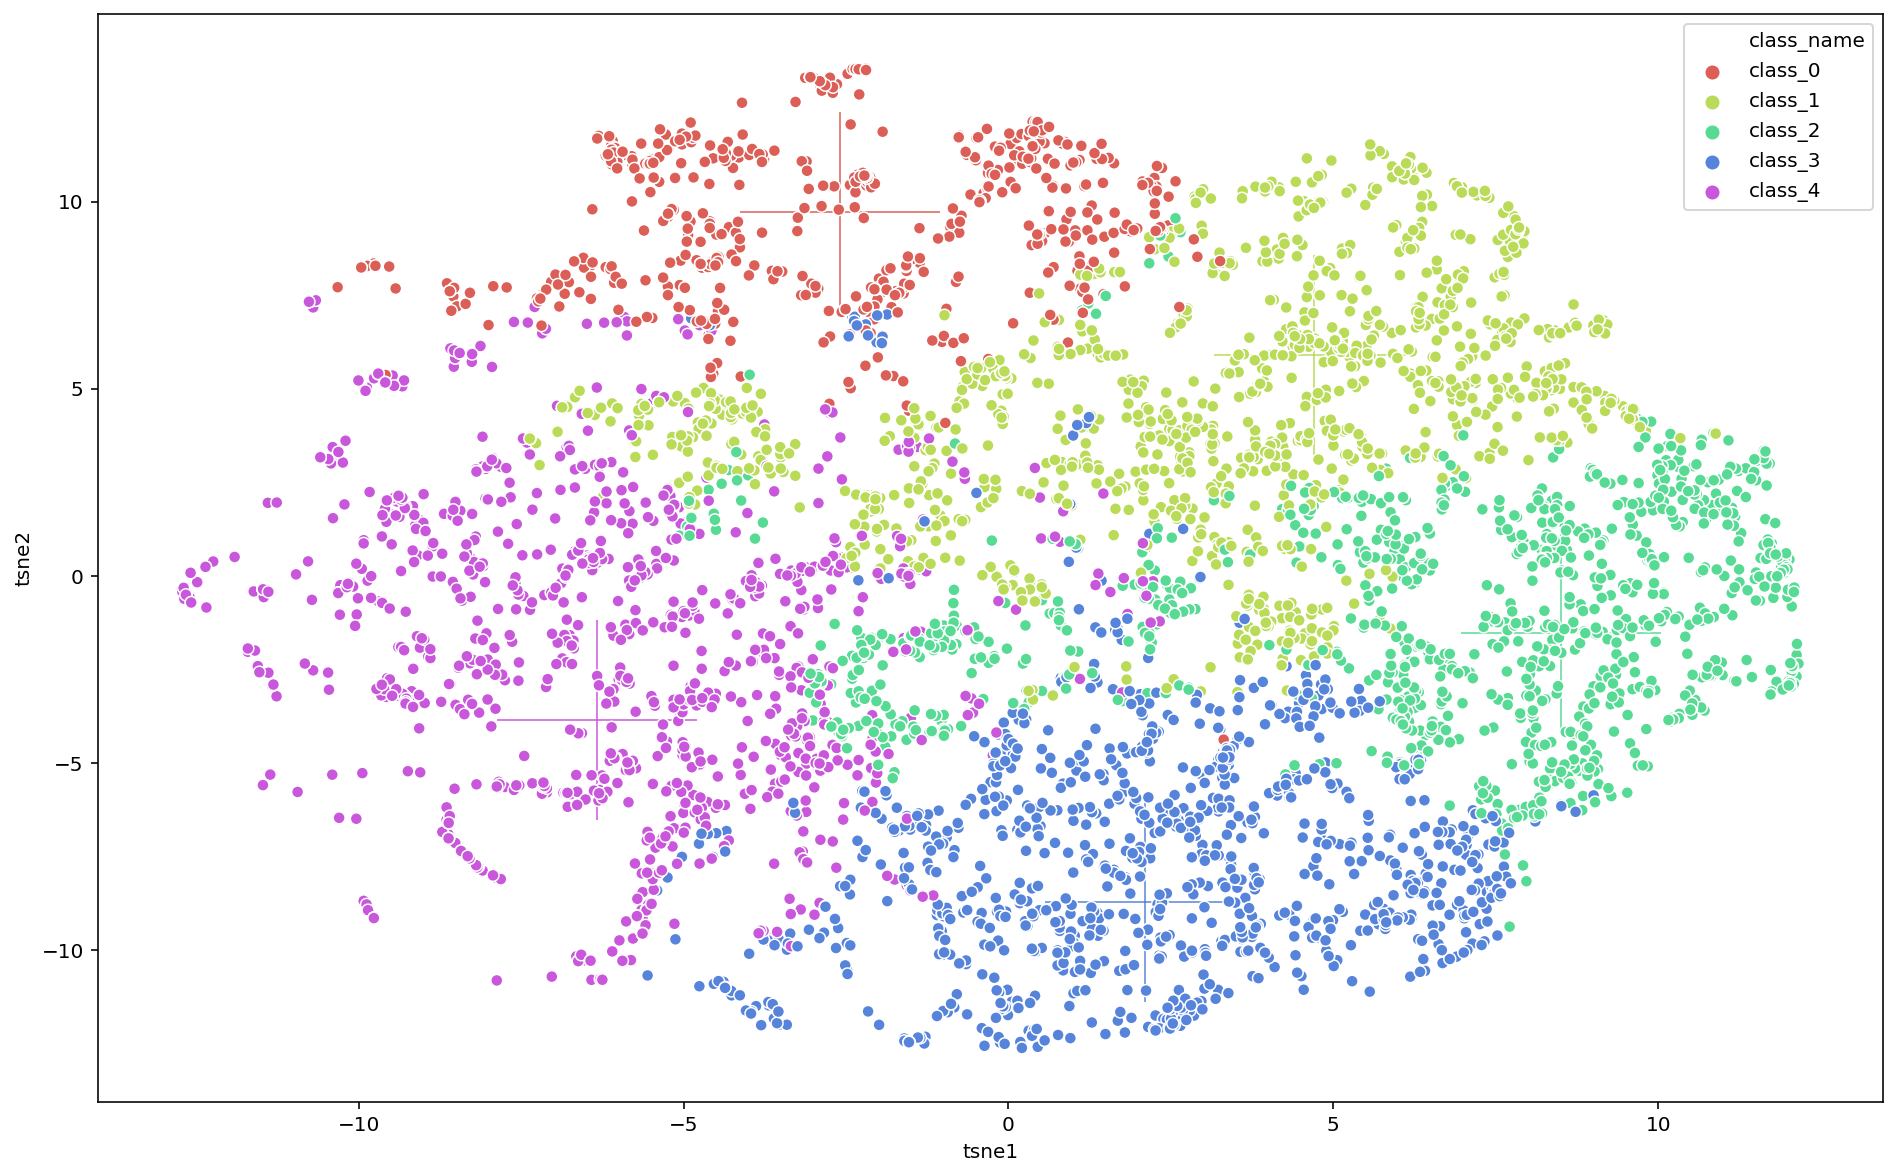

In [47]:
plt.figure(figsize=(16,10))

# plot centroids
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_name",
    palette=sns.color_palette("hls", n_clusters),
    data=centers_df,
    legend="full",
    s=10000,
    marker="+",
    alpha=1.0
);

# plot samples
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="center_idx",
    palette=sns.color_palette("hls", n_clusters),
    data=ann_df,
    legend=False,
    alpha=1.0
);

In [ ]:
# assign class names
# label dataset
# save dataset